### STEP : Taxonomic assignment
#### Taxonomic assignment with Silva 16S

Using Silva 16S classifier for Qiime2. List with all [classifiers](https://docs.qiime2.org/2020.6/data-resources/). 

#### Versions 
- [Silva 138 99% OTUs full-length sequences](https://data.qiime2.org/2020.6/common/silva-138-99-nb-classifier.qza)
- [Silva 138 99% OTUs from 515F/806R region of sequences](https://data.qiime2.org/2020.6/common/silva-138-99-515-806-nb-classifier.qza)
- [Greengenes 13_8 99% OTUs full-length sequences](https://data.qiime2.org/2020.6/common/gg-13-8-99-nb-classifier.qza)
- [Greengenes 13_8 99% OTUs from 515F/806R region of sequences](https://data.qiime2.org/2020.6/common/gg-13-8-99-515-806-nb-classifier.qza)

#### Methods
- [qiime feature-classifier](https://docs.qiime2.org/2022.2/plugins/available/feature-classifier/)
- [qiime feature-classifier classify-sklearn](https://docs.qiime2.org/2021.8/plugins/available/feature-classifier/classify-sklearn)
- [qiime metadata](https://docs.qiime2.org/2022.2/plugins/available/metadata/)
- [classify-hybrid-vsearch-sklearn](https://docs.qiime2.org/2022.2/plugins/available/feature-classifier/classify-hybrid-vsearch-sklearn/)
- [qiime metadata tabulate](https://docs.qiime2.org/2022.2/plugins/available/metadata/tabulate/)
- [qiime taxa](https://docs.qiime2.org/2022.2/plugins/available/taxa/)
- [qiime taxa barplot](https://docs.qiime2.org/2022.2/plugins/available/taxa/barplot/)

## Setup and settings

In [1]:
# Importing packages
import os
import pandas as pd
from qiime2 import Artifact
from qiime2 import Visualization
from qiime2 import Metadata
import qiime2.plugins.metadata.actions as metadata_actions
from qiime2.plugins.metadata.visualizers import tabulate

from qiime2.plugins import feature_classifier
from qiime2.plugins import metadata
from qiime2.plugins import taxa

from qiime2.plugins.taxa.methods import collapse
from qiime2.plugins.taxa.methods import filter_table
from qiime2.plugins.feature_table.methods import filter_samples
from qiime2.plugins.feature_table.visualizers import summarize

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# install scikit-learn specific version to use trained classifier
%pip install --user 'scikit-learn==0.23.1'

Note: you may need to restart the kernel to use updated packages.


In [3]:
# from qiime2.plugins import demux, deblur, quality_filter, \
#                            metadata, feature_table, alignment, \
#                            phylogeny, diversity, emperor, feature_classifier, \
#                            taxa, composition

### Receiving the parameters

The following cell can receive parameters using the [papermill](https://papermill.readthedocs.io/en/latest/) tool.

In [4]:
metadata_file = '/home/lauro/nupeb/rede-micro/redemicro-miliane-nutri/data/raw/metadata/miliane-metadata-CxAC.tsv'
base_dir = os.path.join('/', 'home', 'lauro', 'nupeb', 'rede-micro', 'redemicro-miliane-nutri')
experiment_name = 'miliane-CxAC-trim'
replace_files = False

In [5]:
experiment_folder = os.path.abspath(os.path.join(base_dir, 'experiments', experiment_name))
img_folder = os.path.abspath(os.path.join(experiment_folder, 'imgs'))
sheet_folder = os.path.abspath(os.path.join(experiment_folder, 'sheets'))

### Defining names, paths and flags

In [6]:
# QIIME2 Artifacts folder
qiime_folder = os.path.join(experiment_folder, 'qiime-artifacts')

# Input - DADA2 Artifacts
dada2_tabs_path = os.path.join(qiime_folder, 'dada2-tabs.qza')
dada2_reps_path = os.path.join(qiime_folder, 'dada2-reps.qza')
dada2_stat_path = os.path.join(qiime_folder, 'dada2-stat.qza')

# Input - Taxonomy Classifier - SILVA 138-99
classifier_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'models', 'silva-138-99-nb-classifier.qza'))

# Output - Excel file
excel_path = os.path.join(sheet_folder, 'abundances.xlsx')

# Output - Metataxonomy Artifact
metatax_path = os.path.join(qiime_folder, 'metatax.qza')
metatax_view_path = os.path.join(qiime_folder, 'metatax.qzv')
metatax_bar_path = os.path.join(qiime_folder, 'metatax-bar.qzv')

# Flag - Load or create files
need_tax = not (os.path.isfile(metatax_path)) or replace_files
need_view = not (os.path.isfile(metatax_view_path) or os.path.isfile(metatax_bar_path)) or replace_files

## Step execution

### Load input files

This Step import the QIIME2 `SampleData[PairedEndSequencesWithQuality]` Artifact with all demultiplexed sequences and the `Metadata` file.

In [7]:
metadata_qa = Metadata.load(metadata_file)
tabulate(metadata_qa).visualization

<visualization: Visualization uuid: 0ed61de8-b38f-4f48-8299-7a2a942e2e42>

In [8]:
if not need_tax:
    
    # Load FeatureData[Taxonomy]
    metatax = Artifact.load(metatax_path)
    
else:
    
    # Load TaxonomicClassifier Artifact
    classifier = Artifact.load(classifier_path)
    
    # Load FeatureData[Sequence] Artifact
    reps = Artifact.load(dada2_reps_path)
    
    # Classify ASV features and create a new FeatureData[Taxonomy]
    metatax_qa = feature_classifier.methods.classify_sklearn(reads=reps, classifier=classifier, n_jobs=threads)

    # Save FeatureData[Taxonomy] Artifact
    metatax_qa.classification.save(metatax_path)

# Load FeatureTable[Frequency] Artifact
tabs = Artifact.load(dada2_tabs_path)

In [9]:
if not need_view:
    
    # Load Metatax
    metatax_qv = Visualization.load(metatax_view_path)
    metatax_bar_qv = Visualization.load(metatax_bar_path)
    
else:
    
    # Metataxonomy Table Visualization
    metatax_qv = metadata.visualizers.tabulate(metatax_qa.classification.view(Metadata))
    metatax_qv.visualization.save(metatax_view_path)
    
    # Load TableData[Sequence] Artifact
    tabs = Artifact.load(dada2_tabs_path)
    
    # Barplot Visualization
    # Next, we can view the taxonomic composition of our samples with interactive bar plots. 
    # Generate those plots with the following command and then open the visualization.
    metatax_bar_qv = taxa.visualizers.barplot(tabs, metatax_qa.classification, metadata_qa)
    metatax_bar_qv.visualization.save(metatax_bar_path)

### Metataxonomy analysis

In [10]:
def filter_and_collapse(tab, tax, meta, lvl, exclude=True, exclude_list='uncultured,unidentified,metagenome'):
    from qiime2.plugins.taxa.methods import collapse
    from qiime2.plugins.taxa.methods import filter_table
    from qiime2.plugins.feature_table.visualizers import summarize
    
    to_include = ('d', 'p', 'c', 'o', 'f', 'g', 's')[lvl-1]
    to_include += '__'
    to_exclude = exclude_list if exclude else None
    
#     tab = filter_samples(table=tab, metadata=meta, exclude_ids=False, 
#                          where="[group-id]='C'").filtered_table
    
    filtered_tabs = filter_table(
        table=tab, 
        taxonomy=tax,
        include=to_include,
        exclude=to_exclude,
        mode='contains').filtered_table
    
    collapsed_table = collapse(table=filtered_tabs, taxonomy=tax, level=lvl).collapsed_table
    collapsed_table_view = summarize(table=collapsed_table, sample_metadata=meta).visualization
    
    return collapsed_table, collapsed_table_view

def make_rank(tab, top=None):
    import pandas as pd
    df = tab.view(pd.DataFrame)
    rank_series = df.sum(axis=0).sort_values(ascending=False)
    if top:
        rank_series = rank_series[:top]
    return rank_series

def split_tax(serie):
    level_names = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
    
    

In [11]:
collapsed_table, collapsed_table_view = filter_and_collapse(
    tabs, metatax, metadata_qa, 
    lvl=7, 
    exclude=True, 
    exclude_list='uncultured,unidentified,metagenome')

In [12]:
# from qiime2.plugins.feature_table.methods import filter_features
# from qiime2.plugins.feature_table.methods import filter_samples

# C_group = filter_samples(table=collapsed_table, metadata=metadata_qa, where="[group-id]='AC'", exclude_ids=False).filtered_table
# C_group_view = summarize(table=C_group, sample_metadata=metadata_qa).visualization
# rank = make_rank(C_group, top=10)
# rank

In [13]:
def get_df(tab, col_name):
    df = pd.DataFrame(tab.view(pd.DataFrame).sum(axis=0).sort_values(ascending=False), columns=[col_name])
    new_index = [x.split(';')[-1][3:] for x in df.index]
    df.index = new_index
    return df

def create_rank_df(table, meta, groups):
    df = get_df(table, 'Total')
    for g in groups:
        group = filter_samples(table=table, metadata=meta, where=f"[group-id]='{g}'", exclude_ids=False).filtered_table
        new_df = get_df(group, g)
        df = df.join(new_df, )
    df = df.fillna(0)
    return df

def plot_rank(df, sort_by=None):
    print(sort_by)
    plt.figure()
    sns.set(rc={'figure.figsize':(12,4)})
    df = df.drop(['Total'], axis=1)
    if sort_by and sort_by in df.columns:
        df = df.sort_values(by=sort_by, ascending=False)
    df.plot( kind='bar', stacked=True, )
    plt.ylabel('Abundances')
    plt.xlabel('Species')
    msg = 'x'.join(df.columns)
    plt.title(f'Species Abundances rank for groups {msg}')
    if sort_by and sort_by in df.columns:
        path = os.path.abspath(os.path.join(img_folder, f'abundance-rank-{msg}-order-by-{sort_by}.svg'))
    else:
        path = os.path.abspath(os.path.join(img_folder, f'abundance-rank-{msg}-order-by-total.svg'))
    plt.savefig(path, format='svg')
    plt.show()

                               Total       C      AC
Mucispirillum_schaedleri      8377.0   289.0  8088.0
Bacteroides_caecimuris        7299.0  1913.0  5386.0
Trichinella_pseudospiralis    6927.0  6243.0   684.0
Bacteroides_fragilis          6912.0  1727.0  5185.0
Parabacteroides_goldsteinii   6288.0  1640.0  4648.0
Lactobacillus_intestinalis    3130.0   987.0  2143.0
Clostridiales_bacterium       2541.0  1133.0  1408.0
Chryseobacterium_hominis      1290.0    69.0  1221.0
bacterium_NLAE-zl-H60         1042.0   647.0   395.0
Alistipes_timonensis           595.0   194.0   401.0
Alistipes_finegoldii           353.0    59.0   294.0
Lachnospiraceae_bacterium      336.0   255.0    81.0
Lactobacillus_faecis           220.0   115.0   105.0
Pseudomonas_psychrotolerans     80.0     0.0    80.0
Sphingobacterium_daejeonense    74.0     0.0    74.0
[Clostridium]_colinum           50.0     0.0    50.0
Helicobacter_rodentium          34.0     0.0    34.0
Acinetobacter_sp.               19.0     0.0  

<Figure size 432x288 with 0 Axes>

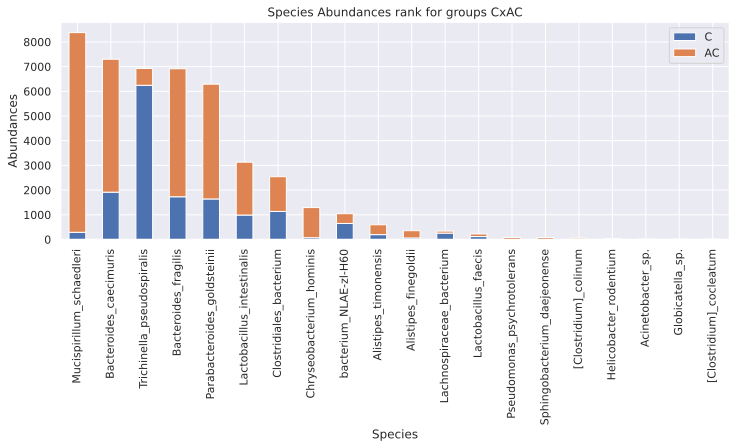

C


<Figure size 864x288 with 0 Axes>

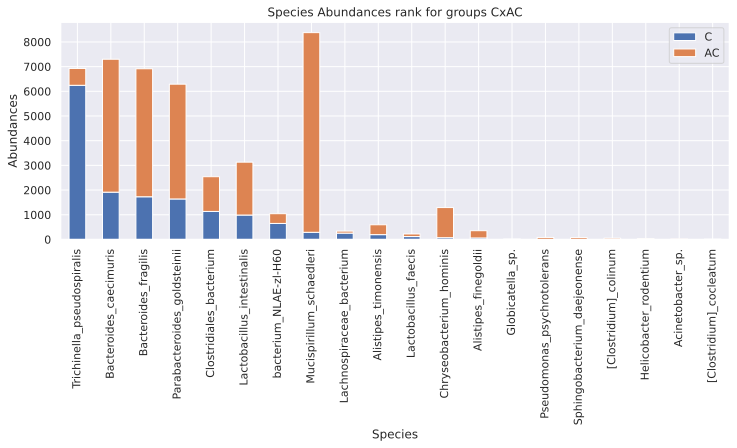

AC


<Figure size 864x288 with 0 Axes>

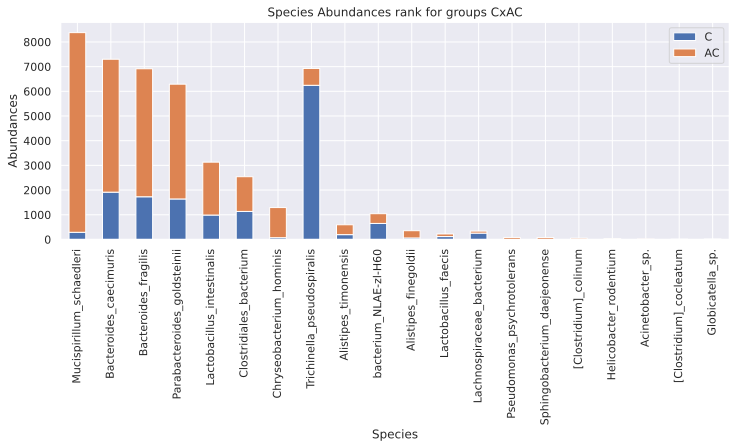

In [14]:
rank_df = create_rank_df(collapsed_table, metadata_qa, groups=('C', 'AC'))
print(rank_df)
for g in ('total', 'C', 'AC'):
    plot_rank(rank_df, sort_by=g)

## Diversity test 
**TODO** colocar no outro notebook esta parte

In [15]:
from qiime2.plugins.diversity.pipelines import alpha
from qiime2.plugins.diversity.visualizers import alpha_group_significance

metrics = ('ace', 'berger_parker_d', 'brillouin_d', 'chao1', 'chao1_ci', 'dominance', 'doubles', 'enspie', 'esty_ci', 'fisher_alpha', 'gini_index', 'goods_coverage', 'heip_e', 'kempton_taylor_q', 'lladser_pe', 'margalef', 'mcintosh_d', 'mcintosh_e', 'menhinick', 'michaelis_menten_fit', 'observed_features', 'osd', 'pielou_e', 'robbins', 'shannon', 'simpson', 'simpson_e', 'singles', 'strong')
metric = 'simpson_e'
alpha_diversity = alpha(table=collapsed_table, metric=metric).alpha_diversity
alpha_group_significance(alpha_diversity=alpha_diversity, metadata=metadata_qa).visualization

<visualization: Visualization uuid: 160cf6a4-5321-4aa8-9662-b902aa5a8218>

In [16]:
# metatax_bar_qv